# XGBoost

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import shap
import seaborn as sns
import time

# Utilizamos una semilla para que los resultados sean reproducibles
RANDOM_STATE = 22

## Carga de datos

In [2]:
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')
test = pd.read_csv('data/test.csv')

In [3]:
X_train = train.copy().drop(columns=['fetal_health'])
y_train = train['fetal_health']

X_val = val.copy().drop(columns=['fetal_health'])
y_val = val['fetal_health']

X_test = test.copy().drop(columns=['fetal_health'])
y_test = test['fetal_health']

En nuestro dataset tenemos 3 clases, identificadas por `[1., 2., 3.]`. Para poder usar XGBoost, necesitamos que las clases estén identificadas por `[0, 1, 2]`. Por tanto, vamos a mapear las clases de la siguiente manera:

- `1. -> 0`
- `2. -> 1`
- `3. -> 2`

In [4]:
mapping = {1: 0, 
           2: 1, 
           3: 2}

y_train = y_train.map(mapping)
y_val = y_val.map(mapping)
y_test = y_test.map(mapping)

## Ajuste del modelo

### Exploración de hiperparámetros

A continuación hacemos una exploración de los hiperparámetros del modelo con el objetivo de conseguir una parametrización óptima para nuestro problema. Para ello, entrenamos el XGBoost con los datos de `train` y evaluamos su rendimiento con los datos de `eval` para cada combinación de hiperparámetros.

In [5]:
max_depths = [i for i in range(1, 21)]
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
gammas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
n_estimators = [50, 100, 200, 300, 400, 500]

best_f1 = 0
best_accuracy = 0
best_depth = 0
best_learning_rate = 0
best_gamma = 0
best_n_estimators = 0

for depth in max_depths:
    for learning_rate in learning_rates:
        for gamma in gammas:
            for n_estimator in n_estimators:
                model = XGBClassifier(random_state=RANDOM_STATE,
                                      max_depth=depth,
                                      learning_rate=learning_rate,
                                      gamma=gamma,
                                      n_estimators=n_estimator,
                                      class_weight='balanced')
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)

                f1 = f1_score(y_val, y_pred, average='weighted')
                accuracy = model.score(X_val, y_val)

                if f1 > best_f1:
                    best_f1 = f1
                    best_accuracy = accuracy
                    best_depth = depth
                    best_learning_rate = learning_rate
                    best_gamma = gamma
                    best_n_estimators = n_estimator

print('Best F1: ', best_f1)
print('Best Accuracy: ', best_accuracy)
print('Best Depth: ', best_depth)
print('Best Learning Rate: ', best_learning_rate)
print('Best Gamma: ', best_gamma)
print('Best N Estimators: ', best_n_estimators)

[20:07:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:07:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:07:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  Thi

Con la mejor combinación de hiperparámetros encontrada, entrenamos el modelo con los datos de `train + eval` y evaluamos su rendimiento con los datos de `test`, que son datos no vistos hasta el momento de predecirlos. De esta forma, podemos hacernos una idea de cómo se comportaría el modelo en producción.

In [6]:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

model = XGBClassifier(random_state=RANDOM_STATE,
                      max_depth=best_depth,
                      learning_rate=best_learning_rate,
                      gamma=best_gamma,
                      n_estimators=best_n_estimators,
                      class_weight='balanced')

init_time = time.time()
model.fit(X_train_val, y_train_val)
fitting_time = time.time() - init_time
print('Fitting time: {:.2f} seconds'.format(fitting_time))
y_pred = model.predict(X_test)

print()
print('Train accuracy: ', model.score(X_train_val, y_train_val))
print('Train f1: ', f1_score(y_train_val, model.predict(X_train_val), average='weighted'))
print('Test accuracy: ', model.score(X_test, y_test))
print('Test f1: ', f1_score(y_test, y_pred, average='weighted'))

[08:09:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting time: 0.51 seconds

Train accuracy:  0.9753086419753086
Train f1:  0.9747915842047804
Test accuracy:  0.9388235294117647
Test f1:  0.9369522496648202


## Análisis de resultados

Para el análisis de resultados de los modelos arbóreos (árbol de decisión y XGBoost), vamos a aprovechar su explicabilidad para poder entender cómo se comporta el modelo y qué variables son las más importantes para la toma de decisiones. Por tanto, vamos a analizar la importancia de variables y los valores SHAP.

In [7]:
# clasification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       331
           1       0.86      0.73      0.79        59
           2       0.91      0.91      0.91        35

    accuracy                           0.94       425
   macro avg       0.91      0.87      0.89       425
weighted avg       0.94      0.94      0.94       425



Comparando estos resultados con los obtenidos con el árbol de decisión, podemos ver que el XGBoost obtiene mejores resultados en todos los casos. La métrica F1 es la que mejor refleja el desbalanceo de los datos, y vemos que mejora para todas las clases en las siguientes cantidades:

| Clase          | Árbol de decisión | XGBoost |
|----------------|-------------------|---------|
| 1 (normal)     | 0.95              | 0.97    |
| 2 (sospechoso) | 0.75              | 0.79    |
| 3 (patológico) | 0.90              | 0.91    |

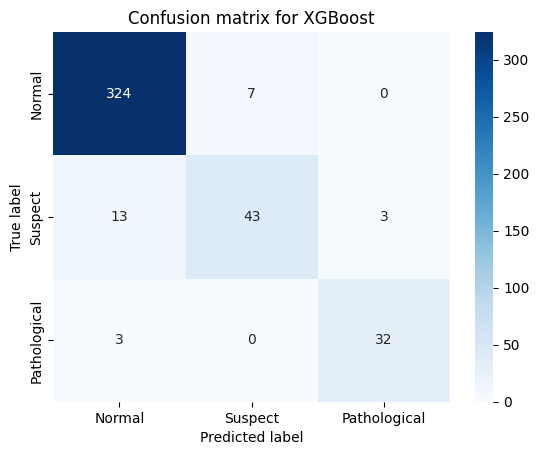

In [8]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Suspect', 'Pathological'], 
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for XGBoost')
plt.show()

Sin embargo, en la matriz de confusión podemos ver que XGBoost sigue clasificando incorrectamente los mismos 3 casos que el árbol de decisión en la clase `Pathological`, dando el mismo valor de Recall en esta clase.

El hecho de que tanto el árbol de decisión como XGBoost obtengan los mismos resultados en la clase `Pathological` puede ser porque estos 3 casos son muy difíciles de clasificar (son outliers en cuanto al valor de sus variables). Esto, junto con el hecho de que hay muy pocos datos de entrenamiento de esta clase, hace que el modelo no sea capaz de aprender a clasificarlos correctamente. Es decir, que ni siquiera un modelo más robusto y complejo como XGBoost es capaz de clasificar correctamente estos casos.

Además, vemos que el número de pacientes `suspect` que son incorrectmente clasificados como `normal` es mayor en XGBoost que en el árbol de decisión (se incrementa en 3). Sin embargo, la clase `normal` es la más mejorada con el uso de XGBoost (mejora en 11 casos).

En resumen, XGBoost obtiene mejore resultados que el árbol de decisión en cuanto al F1, pero el rendimiento identificando casos patológicos sigue siendo el mismo que para el árbol de decisión. Además, hemos visto que esta mejora en F1 viene principalmente dada por la mejora en la clase `normal`, que es la menos interesante de mejorar porque es la que menos problemas de salud tiene.

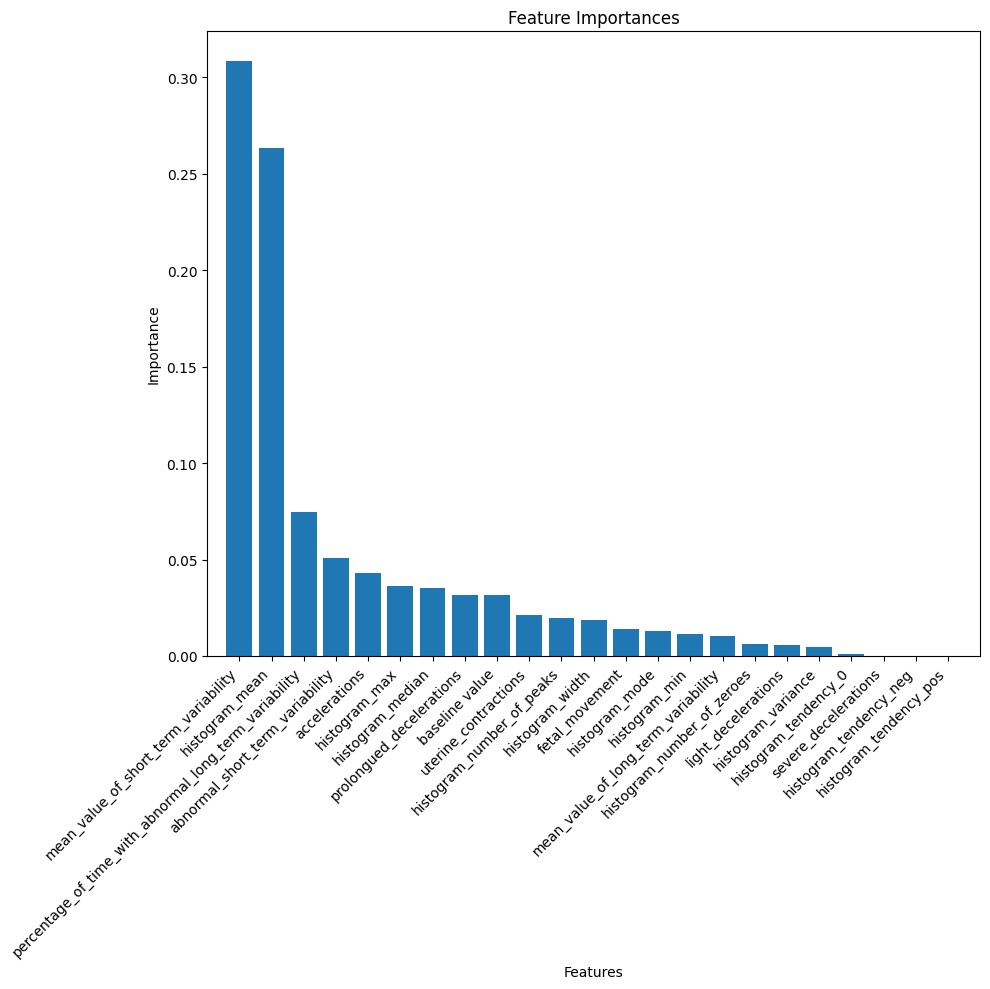

In [9]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 10))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Podemos apreciar que las variables `mean_value_of_short_term_variability` y `histogram_mean` son las más importantes para el modelo con mucha diferencia sobre las siguientes. Esto es coherente con lo que vimos en el árbol de decisión. Además, vemos que para XGBoost se ha acentuado la importancia de estas variables respecto a las demás.

Como ya vimos en el árbol de decisión, esto demuestra la necesidad de aplicar técnicas de aprendizaje automático para poder clasificar correctamente los casos patológicos, ya que las variables más importantes para la clasificación no son las que se esperarían intuitivamente al ver la correlación de variables con la variable objetivo.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


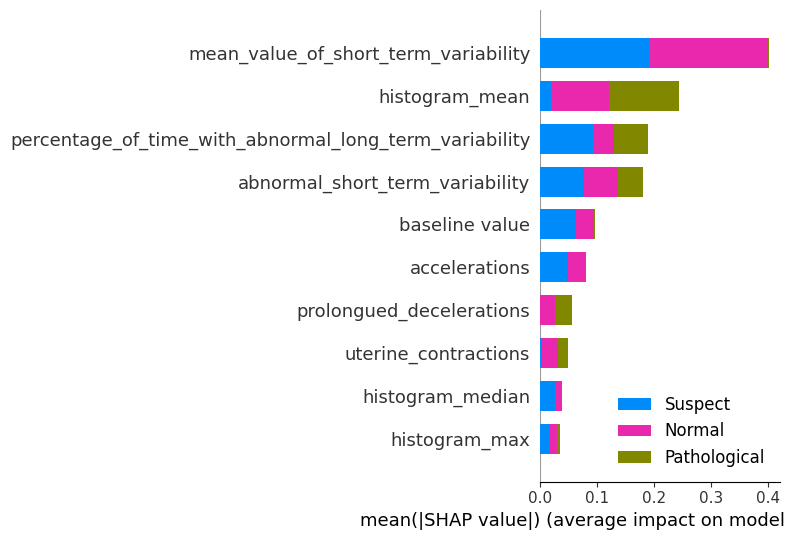

In [10]:
# shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_val)

shap.summary_plot(shap_values, X_train_val, plot_type="bar", class_names=['Normal', 'Suspect', 'Pathological'], max_display=10)

Los valores SHAP de cada variable nos muestran el impacto que tiene esa variable en la predicción del modelo por cada clase.

Los resultados obtenidos para XGBoost son muy curiosos. Vemos que la variable con mayor impacto en la salida del modelo en general es `mean_value_of_short_term_variability`. Sin embargo, esta variable no tiene ningún impacto prácticamente sobre la clase "Pathological".

Para predecir "Pathological", la variable con más impacto sobre la salida del modelo es `histogram_mean`, con mucha diferencia sobre las demás. Esto también era así para el árbol de decisión, por lo que, si nuestro objetivo fuera predecir correctamente los casos patológicos, esta sería la variable principal.

Este análisis nos indica que habría que tener especial cuidado a la hora de tratar con este dato. Si no se dispusiera de él, habría que buscar una forma de obtenerlo o de estimarlo, ya que es la variable más importante para la predicción de casos patológicos.

## Conclusiones

En este notebook hemos visto cómo aplicar XGBoost para clasificar los casos de nuestro dataset. Hemos visto que XGBoost obtiene mejores resultados que el árbol de decisión en cuanto al F1, pero el rendimiento identificando casos patológicos sigue siendo el mismo que para el árbol de decisión.

Además, XGBoost consigue un rendimiento de F1 ligeramente inferior que la red neuronal. Sin embargo, la red neuronal tarda más en entrenar (25 segundos de la red neuronal frente a 0.51 segundos de XGBoost) y es más compleja de interpretar que XGBoost, por lo que con XGBoost ganamos rapidez y explicabilidad.